# H.3 Adiabatic Search of the Ground State

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh

c) Compute the energy gap using exact diagonalisation for different transverse field strengths

In [2]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator, L):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, L) for j in range(L)]

def Hamiltonian(h=1, J=1, L=4):
    # initialize matrices
    H = csr_matrix((2**L, 2**L), dtype=np.complex128)
    sz_list = all_operators(sigma_z, L)
    sx_list = all_operators(sigma_x, L)

    for i in range(L-1):
        H += -J*(sz_list[i] @ sz_list[i+1]) - h*(sx_list[i])
    return H

In [3]:
def energy_gap(L, h_max, steps):
    delta_Es = []

    for h in np.linspace(0, h_max, steps):
        H = Hamiltonian(h=h, J=1, L=L)

        # diagonalize the Hamiltonian
        e, v = eigh(H.toarray())
        
        delta_Es.append(e[2] - e[0])  # due to symmetry, this works (degenerate ground state)
    return delta_Es

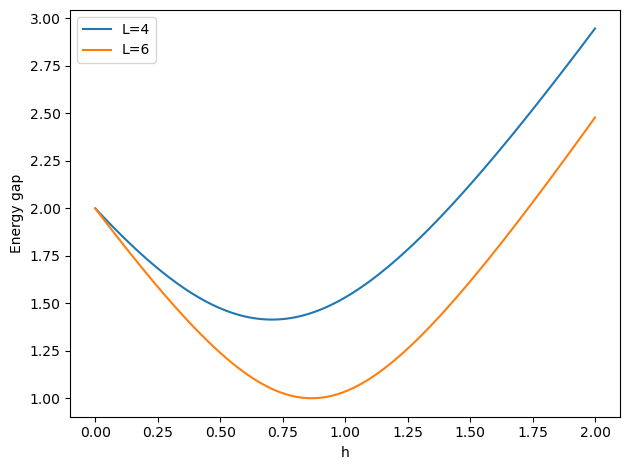

In [4]:
nsteps, h_max = 100, 2

delta_Es_L4 = energy_gap(L=4, h_max=h_max, steps=nsteps)
delta_Es_L6 = energy_gap(L=6, h_max=h_max, steps=nsteps)

fig, ax = plt.subplots()

ax.plot(np.linspace(0, h_max, nsteps), delta_Es_L4, label='L=4')
ax.plot(np.linspace(0, h_max, nsteps), delta_Es_L6, label='L=6')

ax.set_xlabel('h')
ax.set_ylabel('Energy gap')

ax.legend()

plt.tight_layout()

d) Compute the ground state of the TFIM from the ground state without an external field

In [5]:
def wrap_hamiltonian(h, J, L):   # create wrappers to make function suitable for any integration function
    def wrapper(s):
        return Hamiltonian(h=h, J=J, L=L)
    return wrapper

In [6]:
def dpsi_dt(s, psi, H, L):
    psi = psi.view(dtype=np.complex128)
    return (-1j * H @ psi).view(dtype=np.float64)    

def dpsidt_wrapper(h, J, L):
    H_int = Hamiltonian(h, J, L)
    H0 = Hamiltonian(0, J, L)

    def wrapper(s, psi):
        H = (1 - s) * H0 + s * H_int
        return dpsi_dt(s, psi, H=H, L=L)
    
    return wrapper

In [7]:
h, J, L = 2, 1, 4

ground_state_psi = np.zeros(2**L, dtype=np.complex128)
ground_state_psi[0] = 1
psi0 = ground_state_psi

In [8]:
# integration
dpsidt = dpsidt_wrapper(h, J, L)
Nsteps = 1000

sol = solve_ivp(dpsidt, t_span = (0, 1), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, 1, Nsteps))
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)
adiabatic_groundstate = psi_tau_list[-1]

e) Comparison of ground state energies found with the adiabatic search and with exact diagonalization over time

In [9]:
exact_E0 = np.zeros(Nsteps)
adiabatic_E0 = np.zeros(Nsteps)
overlap = np.zeros(Nsteps)

for i, s in enumerate(np.linspace(0, 1, Nsteps)):
    # Get the Hamiltonian at time s
    H = (1 - s) * Hamiltonian(0, J, L) + s * Hamiltonian(h, J, L)
    
    # exact ground state energy at time s
    e, v = eigh(H.toarray())

    exact_E0[i] = e[0]

    # adiabatic ground state energy at time s
    adiabatic_E0[i] = np.real(psi_tau_list[i] @ H @ psi_tau_list[i].conjugate())

    # overlap between evolving psi and exact ground state -> compare found ground state wit both degenerate states
    overlap[i] = np.max([np.abs(psi_tau_list[i] @ v[:, 0].conjugate()), np.abs(psi_tau_list[i] @ v[:, 1].conjugate())])

Text(0, 0.5, 'Groundstate Energy $E_0$')

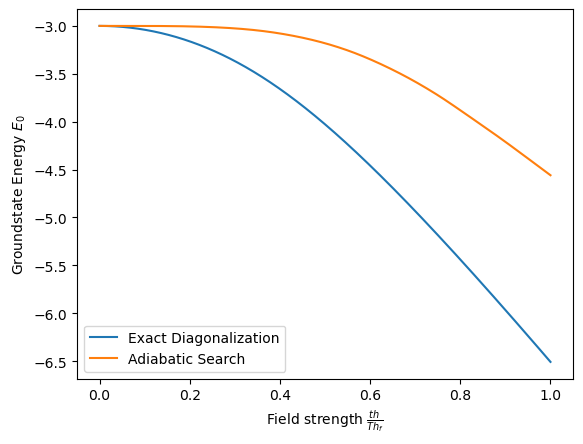

In [18]:
plt.plot(sol.t, exact_E0, label='Exact Diagonalization')
plt.plot(sol.t, adiabatic_E0, label='Adiabatic Search')
plt.legend()
plt.xlabel(r'Field strength $\frac{th}{Th_f}$')
plt.ylabel(r'Groundstate Energy $E_0$')

f) Comparison of the ground states found with the adiabatic search and with exact diagonalization over time

Text(0, 0.5, '$<\\psi_{0}^{ad}|\\psi_{0}^{ED}>$')

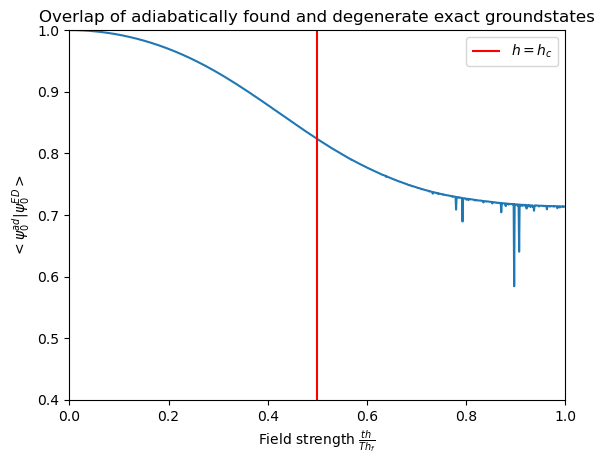

In [19]:
plt.plot(sol.t, overlap) #already calculated in time loop in e)
plt.xlabel(r'Field strength $\frac{th}{Th_f}$')
plt.xlim(0,1)
plt.ylim(0.4,1)
plt.vlines(0.5,0,1,color="red",label=r'$h=h_c$')
plt.legend()
plt.title(r'Overlap of adiabatically found and degenerate exact groundstates')
plt.ylabel(r'$<\psi_{0}^{ad}|\psi_{0}^{ED}>$')

g) At the quantum phase transition the adiabatic search stops evolving away from the true groundstate and starts converging towards it.
The found ground state as well as its energy should match the results obtained with exact diagonalization for the final field strength $h_f$. The spikes visible for high magnetic field strengths could indicate that the calculated state left the ground state of the system, which could be due to a too fast evolution, however they don't disappear for higher numbers of timesteps.